In [1]:
import os
import json
import random
import imgkit
import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from itertools import compress
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import ttest_ind
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
from IPython.display import HTML, display
from pandas.io.json import json_normalize
import matplotlib.patheffects as path_effects
from matplotlib.font_manager import FontProperties

from AlphaStream.Models import Symbol

import warnings
warnings.filterwarnings('ignore')

In [44]:
# Basic data collection
# Fetch backtest files and fetch statistics

def CollectData(path):
    dirs = os.listdir(path)
    backtests = []
    for directory in dirs:
        for file in os.listdir(f'{path}/{directory}'):
            if file.endswith('.json'):
                backtests.append(f'{path}/{directory}/{file}')   
                
    drawdown = []
    sharpe = []
    alpha = []
    beta = []
    info_ratio = []
    tracking_error = []
    std_dev = []
    expectancy = []
    cagr = []
    treynor = []
    curves = []
    mean_returns = []
    profit_factor = []
    drawdown_duration = []
        
    for backtest in backtests:
        with open(backtest, 'r') as fp:
            data = json.load(fp)
            if not isinstance(data, dict):
                continue
            if data['TotalPerformance'] is None:
                continue
            if data['TotalPerformance']['TradeStatistics']['TotalNumberOfTrades'] is None:
                continue
            if data['TotalPerformance']['TradeStatistics']['TotalNumberOfTrades'] == 0:
                continue

            curve = pd.DataFrame(data['Charts']['Strategy Equity']['Series']['Equity']['Values']).set_index('x')
            curve.index = [datetime.utcfromtimestamp(j) for j in curve.index.values]
            curve = curve / curve.iloc[0]
            if curve.pct_change().dropna().abs().sum().values[0] == 0:
                continue

            port_stats = data['TotalPerformance']['PortfolioStatistics']
            drawdown.append(port_stats['Drawdown'])
            alpha.append(port_stats['Alpha'])
            beta.append(port_stats['Beta'])
            info_ratio.append(port_stats['InformationRatio'])
            tracking_error.append(port_stats['TrackingError'])
            sharpe.append(port_stats['SharpeRatio'])
            std_dev.append(port_stats['AnnualStandardDeviation'])
            expectancy.append(port_stats['Expectancy'])
            cagr.append(port_stats['CompoundingAnnualReturn'])
            treynor.append(port_stats['TreynorRatio'])
            profit_factor.append(data['TotalPerformance']['TradeStatistics']['ProfitFactor'])
            times = data['TotalPerformance']['TradeStatistics']['MaximumDrawdownDuration'].split(":")
            drawdown_duration.append(float(times[0]) + float(times[1])/60 + float(times[2])/3600)

            mean_ret = curve.pct_change().mean()
            mean_returns.append(mean_ret.values[0])
            curves.append((mean_ret.values[0], curve))
            
            backtest_statistics.append({
                'Drawdown': port_stats['Drawdown'],
                'Drawdown Duration': port_stats['Drawdown Duration']
            })
        
    return backtests, drawdown, sharpe, alpha, beta, info_ratio, tracking_error, std_dev, expectancy, cagr, treynor, profit_factor, drawdown_duration, curves, mean_returns
    

# Trim outlying data points
def TrimOutliers(dat):        
    q1 = np.quantile(dat, 0.25)
    q3 = np.quantile(dat, 0.75)
    iqr = q3-q1
    outlier_above = q3 + (1.5*iqr)
    outlier_below = q1 - (1.5*iqr)
    return list(compress(dat,(dat > outlier_below) & (dat < outlier_above)))

# Get percentiles
def GetPercentiles(data):
    quantiles = []
    for i in np.linspace(10, 90, 9):
        percentile = np.percentile(data, i, interpolation = 'lower')
        idx = data.index(percentile)
        quantiles.append(data[idx])
    return quantiles

In [5]:
# Get backtest data using local path
path = "PATH_TO_BACKTEST_FILES"
backtests, drawdown, sharpe, alpha, beta, info_ratio, tracking_error, std_dev, expectancy, cagr, treynor, profit_factor, drawdown_duration, curves, mean_returns = CollectData(path)

In [49]:
# Get and clean Insight data
# This is a work in progress and will need some cleaning up
def CleanInsightData(path):
    dirs = os.listdir(path)
    insight_files = []
    backtest_files = []
    for directory in dirs:
        for file in os.listdir(f'{path}/{directory}'):
            if file.endswith('insights.json'):
                insight_files.append(f'{path}/{directory}/{file}')
            elif file.endswith('.json') and not file.endswith('events.json'):
                backtest_files.append(f'{path}/{directory}/{file}')

    magnitude_score_mean = []
    direction_score_mean = []
    magnitude_accuracy_mean = []
    correct_mag = []
    incorrect_mag = []
    drawdowns_correct = []
    drawdowns_fail = []
    drawdowns = []
    sharpes_correct = []
    sharpes_fail = []
    sharpes = []
    
    magnitude_accuracy = pd.DataFrame()
    magnitude_score = pd.DataFrame()
    direction_score = pd.DataFrame()
    
    for i, b in zip(insight_files, backtest_files):
        dat = json.load(open(i))
        if len(dat) < 1:
            continue
        if 'reference-final' not in dat[0].keys():
            continue
        insights = json_normalize(dat).drop(['group-id'], axis=1)
        insights = insights[insights['score-final']]
        insights['asset-class'] = [Symbol(x).SecurityType.lower() for x in insights['symbol']]
        for col in ['close-time', 'created-time', 'generated-time']:
            insights[col] = [datetime.utcfromtimestamp(x) for x in insights[col].values]

        insights['magnitude'] = insights['magnitude'].replace([None], np.nan)
        insights['magnitude'] = [row['magnitude'] if row['direction'] == 'up' else -row['magnitude'] for index, row in insights.iterrows()]

        insights['direction'] = insights['direction'].replace([-1, 1, 0], ['down', 'up', 'flat'])
        insights['magnitude-prediction'] = insights['reference'].mul(1 + insights['magnitude'])
        insights['magnitude-accuracy'] = insights['magnitude-prediction'].div(insights['reference-final'])

        correct_mag.append(
            insights['magnitude-accuracy'].loc[insights['score-magnitude'] == 0].dropna().replace([np.inf, -np.inf],
                                                                                                  np.nan))
        incorrect_mag.append(
            insights['magnitude-accuracy'].loc[insights['score-magnitude'] == 1].dropna().replace([np.inf, -np.inf],
                                                                                                  np.nan))

        portfolioValue = GetPortfolioValue(b)
        if portfolioValue is None:
            continue

        ddc, ddf, dd, src, srf, sr = ProcessEquityCurve(insights, portfolioValue)
        drawdowns_correct += ddc
        drawdowns_fail += ddf
        drawdowns += dd
        sharpes_correct += src
        sharpes_fail += srf
        sharpes += sr
        try:
            magnitude_score_mean.append(insights['score-magnitude'].mean())
        except:
            continue
        try:
            direction_score_mean.append(insights['score-direction'].mean())
        except:
            continue
        try:
            magnitude_accuracy_mean.append(insights['magnitude-accuracy'].mean())
        except:
            continue
        
        j = insights['score-magnitude'].rolling(15).mean()
        j.name = b[:-5]
        k = insights['score-direction'].rolling(15).mean()
        k.name = b[:-5]
        l = insights['magnitude-accuracy']
        l.name = b[:-5]
        magnitude_score = magnitude_score.join(j, how = 'outer')
        direction_score = direction_score.join(k, how = 'outer')
        magnitude_accuracy = magnitude_accuracy.join(l, how = 'outer')

    return magnitude_score, direction_score, magnitude_accuracy, magnitude_score_mean, direction_score_mean, magnitude_accuracy_mean, drawdowns_correct, drawdowns_fail, drawdowns, sharpes_correct, sharpes_fail, sharpes


# Get equity curve from backtest to do drawdown/sharpe analysis
# Now unnecessary -- needs to be done based on Insight symbol price change
def ProcessEquityCurve(insights, portfolioValue):
    drawdowns_fail = []
    drawdowns_correct = []
    drawdowns = []
    sharpes_correct = []
    sharpes_fail = []
    sharpes = []
    for index, row in insights.iterrows():
        end_time = row['close-time']
        begin_time = row['created-time']
        port_val = portfolioValue[begin_time:end_time]
        if port_val.empty:
            drawdowns += [0]
            sharpes += [0]
            if row['score-magnitude'] == 0:
                drawdowns_correct += [0]
                sharpes_correct += [0]
            elif row['score-magnitude'] == 0:
                drawdowns_fail += [0]
                sharpes_fail += [0]
            continue

        sharpes.append((port_val.pct_change().mean() / port_val.pct_change().std()).values[0])
        curve = port_val['Equity'].values
        i = np.argmax(np.maximum.accumulate(curve) - curve)
        if i == 0:
            drawdowns.append(0)
            if row['score-magnitude'] == 0:
                drawdowns_correct += [0]
                sharpes_correct += [0]
            elif row['score-magnitude'] == 0:
                drawdowns_fail += [0]
                sharpes_fail += [0]
            continue
        j = np.argmax(curve[:i])
        drawdowns.append(round(abs((curve[i] / curve[j]) - 1), 3))
        if row['score-magnitude'] == 0:
            drawdowns_correct.append(round(abs((curve[i] / curve[j]) - 1), 3))
            sharpes_correct.append((port_val.pct_change().mean() / port_val.pct_change().std()).values[0])
        elif row['score-magnitude'] == 1:
            drawdowns_fail.append(round(abs((curve[i] / curve[j]) - 1), 3))
            sharpes_fail.append((port_val.pct_change().mean() / port_val.pct_change().std()).values[0])

    return drawdowns_correct, drawdowns_fail, drawdowns, sharpes_correct, sharpes_fail, sharpes



def GetPortfolioValue(b):
    with open(b, 'r') as fp:
        data = json.load(fp)
    if data['Charts'] is None:
        return None
    if data['Charts']['Strategy Equity'] is None:
        return None
    if data['Charts']['Strategy Equity']['Series'] is None:
        None
    if data['Charts']['Strategy Equity']['Series']['Equity'] is None:
        return None
    strategy = data['Charts']['Strategy Equity']['Series']['Equity']
    if len(strategy['Values']) < 2:
        return None
    strategy = pd.DataFrame(strategy['Values']).set_index('x')
    strategy.index = [datetime.fromtimestamp(x) for x in strategy.index.values]
    strategy.index.name = "Time"
    strategy.columns = ['Equity']
    strategy = strategy.ffill()
    dts = [x for x in strategy.index.values]
    dts = (dts - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    dts = [datetime.utcfromtimestamp(x) >= datetime(2015, 1, 1) for x in dts]
    strategy = strategy.loc[dts]
    if strategy.empty:
        return None
    return strategy / strategy.iloc[0]

In [50]:
# Get and clean Insight data
path = "DIR_PATH_TO_INSIGHT_PATHS"
magnitude_scores, direction_scores, magnitude_accuracy, magnitude_score_mean, direction_score_mean, magnitude_accuracy_mean, drawdowns_correct, drawdowns_fail, drawdowns, sharpes_correct, sharpes_fail, sharpes = CleanInsightData(path)

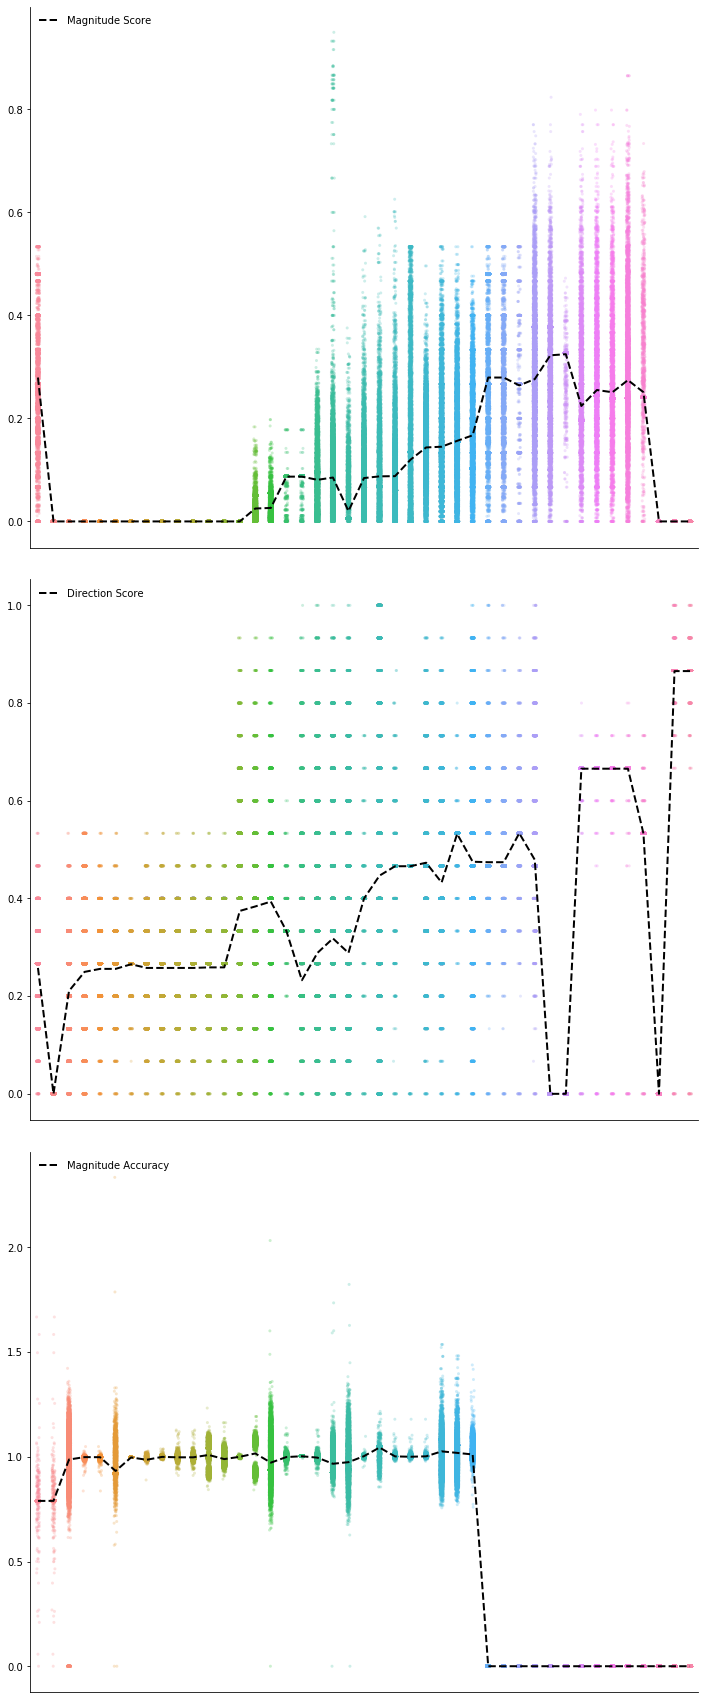

In [51]:
# Needs serious modification
# 3D plots - alpha, universe, PCM

# Get data
dat_insights = [magnitude_scores, direction_scores, magnitude_accuracy]

# Sort by mean
magnitude_scores_sorted = sorted([(magnitude_scores[col], magnitude_scores[col].mean()) for col in magnitude_scores.columns], key = lambda k:k[1])
direction_scores_sorted = sorted([(direction_scores[col], direction_scores[col].mean()) for col in direction_scores.columns], key = lambda k:k[1])
magnitude_accuracy_sorted = sorted([(magnitude_accuracy[col], magnitude_accuracy[col].mean()) for col in magnitude_accuracy.columns], key = lambda k:k[1])

# Fetch curves
mag_score = [x[0] for x in magnitude_scores_sorted]
dir_score = [x[0] for x in direction_scores_sorted]
acc_score = [x[0] for x in magnitude_accuracy_sorted]

fig, axs = plt.subplots(3,1, constrained_layout=True, figsize = (10,24))

# Turn lists into DFs
def GetDF(data):
    df =pd.DataFrame()
    for i,x in enumerate(data):
        x.name = f'{i}'
        df = df.join(x, how = 'outer')
    return df



mag_score_df = GetDF(mag_score)
dir_score_df = GetDF(dir_score)
acc_score_df = GetDF(acc_score)
dat_insights = [mag_score_df, dir_score_df, acc_score_df]


labels = ["Magnitude Score", 'Direction Score', 'Magnitude Accuracy']

fig.tight_layout()
for i, ax in enumerate(axs):
    dat_to_plot = pd.DataFrame()
    curve = dat_insights[i]
    means = curve.ffill().fillna(0).mean()
    dat_to_plot = curve.ffill().fillna(0)    
    ax.plot(range(len(means)), means, '--', linewidth=2, color = 'black', zorder = 10, label = labels[i])
    p = sns.stripplot(data = dat_to_plot, jitter=True, alpha = 0.25, size = 3, ax=ax)
    p.set(xticklabels=[], xticks = [])#, ylim = (-0.05, 0.05))
    sns.despine(fig=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    ax.legend(frameon = False, loc = 'upper left')

plt.show()

In [52]:
# Clean Insight data -- needs to be done once a large sample is acquired
cleaned_mag_score = magnitude_score_mean#TrimOutliers(magnitude_score_mean)
cleaned_dir_score = direction_score_mean#TrimOutliers(direction_score_mean)
cleaned_mag_accuracy = magnitude_accuracy_mean#TrimOutliers(magnitude_accuracy)
cleaned_dd_correct = drawdowns_correct#TrimOutliers(drawdowns_correct)
cleaned_dd_fail = drawdowns_fail#TrimOutliers(drawdowns_fail)
cleaned_dd = drawdowns#TrimOutliers(drawdowns)
cleaned_sr_correct = sharpes_correct#TrimOutliers(sharpes_correct)
cleaned_sr_fail = sharpes_fail #TrimOutliers(sharpes_fail)
cleaned_sr = sharpes #TrimOutliers(sharpes)

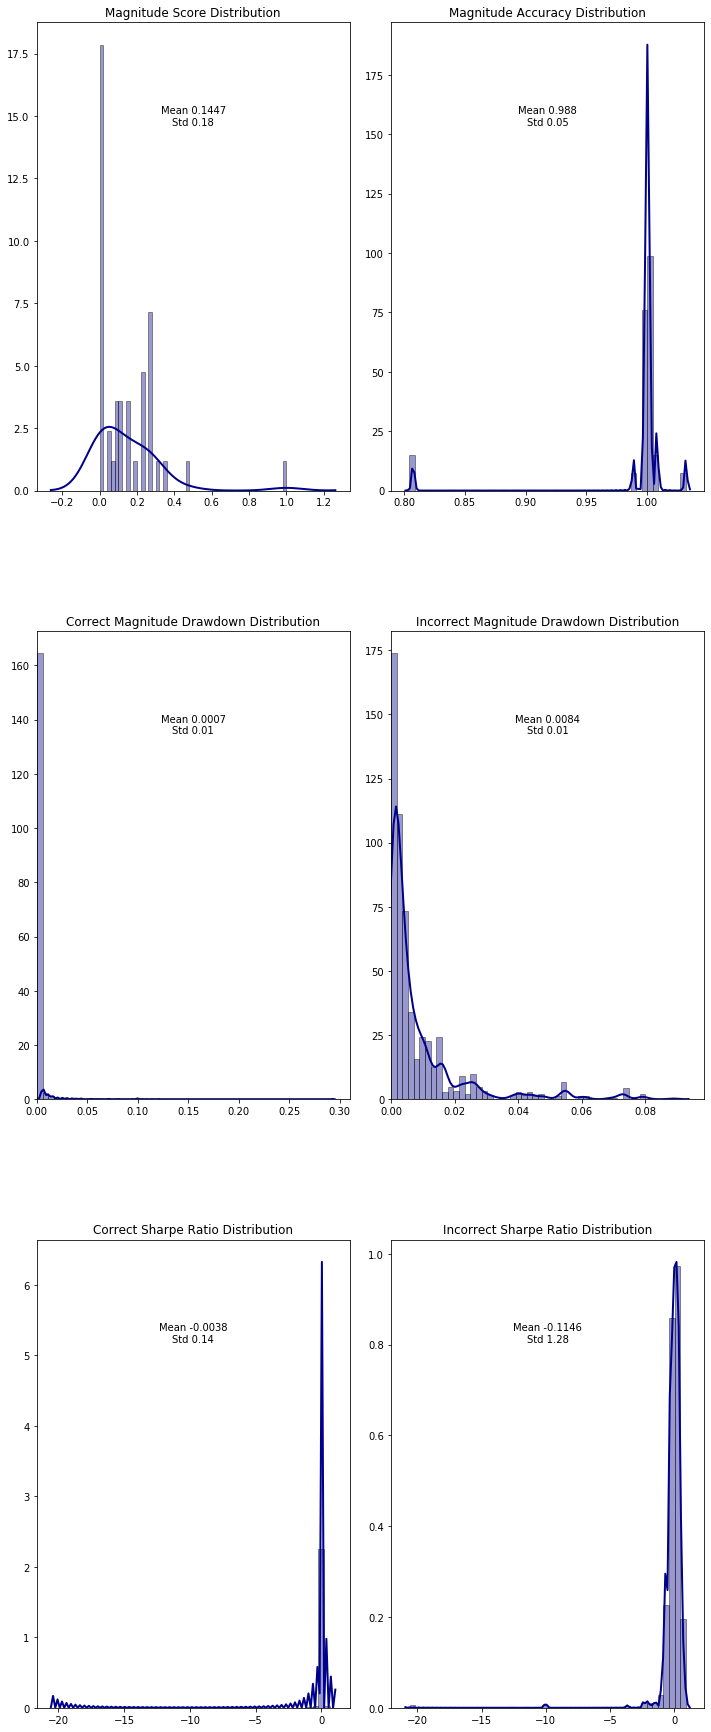

In [55]:
# Plot distribution data

dat = [[cleaned_mag_score, cleaned_mag_accuracy],
       [cleaned_dd_correct, cleaned_dd_fail],
       [cleaned_sr_correct, cleaned_sr_fail]
      ]
fig, axs = plt.subplots(3,2, constrained_layout=True, figsize = (10,24))

fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

labels = [["Magnitude Score", "Magnitude Accuracy"],
          ["Correct Magnitude Drawdown", "Incorrect Magnitude Drawdown"],
          ["Correct Sharpe Ratio", "Incorrect Sharpe Ratio"]
         ]
for i, ax in enumerate(axs):
    ax[0].set_title(f"{labels[i][0]} Distribution")
    ax[0].text(0.5, 0.8, f'Mean {round(np.mean(pd.Series(dat[i][0]).dropna().values),4)}\nStd {round(np.std(pd.Series(dat[i][0]).dropna().values),2)}', horizontalalignment='center',
               verticalalignment='center', transform=ax[0].transAxes, bbox={'facecolor':'white', 'edgecolor':'none', 'pad':10})
    x = sns.distplot(pd.Series(dat[i][0]).dropna(), hist=True, kde=True, bins = 50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax = ax[0])
    if all([j >= 0 for j in dat[i][0]]):
        x.set(xlim = (0))

    ax[1].set_title(f"{labels[i][1]} Distribution")
    ax[1].text(0.5, 0.8, f'Mean {round(np.mean(pd.Series(dat[i][1]).dropna().values),4)}\nStd {round(np.std(pd.Series(dat[i][1]).dropna().values),2)}', horizontalalignment='center',
               verticalalignment='center', transform=ax[1].transAxes, bbox={'facecolor':'white', 'edgecolor':'none', 'pad':10})
    x = sns.distplot(pd.Series(dat[i][1]).dropna(), hist=True, kde=True, bins = 50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax = ax[1])
    if all([j >= 0 for j in dat[i][1]]):
        x.set(xlim = (0))
# plt.savefig('C:/Users/Jack Simonson/QuantConnect/AlphaModuleEvaluationFiles/InsightDistributionPlots.png', dpi = 90, bbox_inches='tight')
# plt.close()
plt.show()

In [46]:
# Clean backtest data
cleaned_drawdown = TrimOutliers(drawdown)
cleaned_sharpe = TrimOutliers(sharpe)
cleaned_beta = TrimOutliers(beta)
cleaned_alpha = TrimOutliers(alpha)
cleaned_info_ratio = TrimOutliers(info_ratio)
cleaned_tracking_error = TrimOutliers(tracking_error)
cleaned_std_dev = TrimOutliers(std_dev)
cleaned_expectancy = TrimOutliers(expectancy)
cleaned_cagr = TrimOutliers(cagr)
cleaned_treynor = TrimOutliers(treynor)
cleaned_profit_factor = TrimOutliers(profit_factor)
cleaned_drawdown_duration = TrimOutliers(drawdown_duration)
cleaned_mean_ret = TrimOutliers(mean_returns)

In [48]:
# Get quantiles for cleaned data
drawdown_q = sorted(GetPercentiles(cleaned_drawdown), reverse = True)
sharpe_q = GetPercentiles(cleaned_sharpe)
alpha_q = GetPercentiles(cleaned_alpha)
beta_q = sorted(GetPercentiles(cleaned_beta), reverse = True)
info_ratio_q = GetPercentiles(cleaned_info_ratio)
tracking_error_q = GetPercentiles(cleaned_tracking_error)
std_dev_q = sorted(GetPercentiles(cleaned_std_dev), reverse = True)
expectancy_q = GetPercentiles(cleaned_expectancy)
cagr_q = GetPercentiles(cleaned_cagr)
treynor_q = GetPercentiles(cleaned_treynor)
profit_factor_q = GetPercentiles(cleaned_profit_factor)
drawdown_duration_q = GetPercentiles(cleaned_drawdown_duration)
mean_ret_q = GetPercentiles(cleaned_mean_ret)

In [49]:
# sort curves based on mean return
cleaned_curves = sorted(curves, key=lambda k:k[0])
cleaned_curves = [x for x in cleaned_curves if x[0] in cleaned_mean_ret]

In [8]:
# Plot backtest returns
def PlotAggregateBacktests(cleaned_curves = [], save = False):
    curve_data_for_aggregate = pd.DataFrame()
    for i, x in enumerate(cleaned_curves):
        c = x[1]
        if c[c.index > datetime(2018, 1, 1)].dropna().empty:
            continue
        c.columns = [i+1]
        c = c / c.iloc[0]
        c = c.ffill()
        if c.pct_change().mean().values[0] == 0:
            continue
        c = c.resample('D').mean()
        curve_data_for_aggregate = curve_data_for_aggregate.join(c, how = 'outer')
    curve_data_for_aggregate = curve_data_for_aggregate.ffill()
    curve_data_for_aggregate = curve_data_for_aggregate[curve_data_for_aggregate.index > datetime(2018, 1, 1)].ffill().dropna()

    resorted_curves = []
    for col in curve_data_for_aggregate.columns:
        resorted_curves.append((curve_data_for_aggregate[col].pct_change().mean(), curve_data_for_aggregate[col]))
    resorted_curves = sorted(resorted_curves, key=lambda k:k[0])
    
    curve_data_for_aggregate = pd.DataFrame()
    for i, x in enumerate(resorted_curves):
        c = x[1]
        c.columns = [i+1]
        if c.pct_change().mean() == 0:
            continue
        curve_data_for_aggregate = curve_data_for_aggregate.join(c, how = 'outer')
    curve_data_for_aggregate = curve_data_for_aggregate.ffill()
    
    
    returns = curve_data_for_aggregate.pct_change()
    means = returns.mean().values
    
    
    plt.figure(figsize = (12,8))

    plt.plot(range(len(means)), means, '--', linewidth=2, color = 'black', zorder = 10, label = 'Mean Return')
    p = sns.stripplot(data = returns, jitter=True, alpha = 0.25, size = 3)
    p.set(xticklabels=[], xticks = [])#, ylim = (-0.05, 0.05))
    sns.despine(fig=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.legend(frameon = False, loc = 'upper left')
    plt.ylabel(ylabel = 'Returns', fontsize = 10, weight = 'bold')
    plt.title('Backtest Daily Returns', weight = 'bold')

    if save:
        plt.savefig('C:/Users/Jack Simonson/QuantConnect/AlphaModuleEvaluationFiles/AggregateBacktestStatistics_discrete_analysis.png', dpi = 90, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

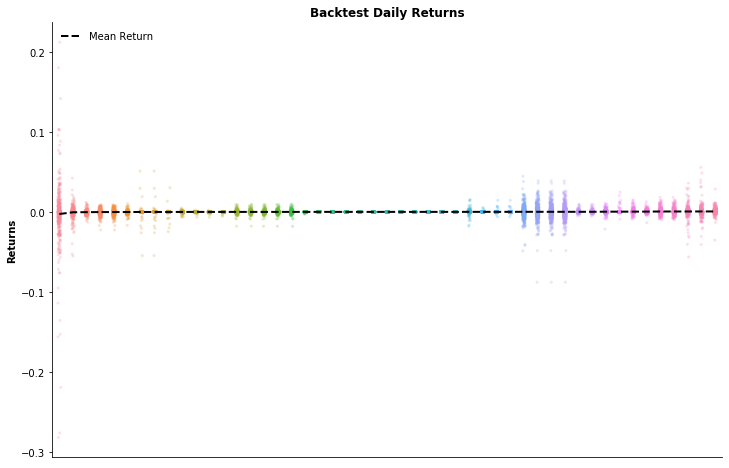

In [9]:
PlotAggregateBacktests(cleaned_curves)

In [56]:
# Plot percentile plots
# Returns boxplots (bug)
# Bar plots of mean/std
# Cumulative returns
# Percentile data table
def PlotPercentiles(cleaned_drawdown = [], cleaned_sharpe = [], cleaned_beta = [], cleaned_alpha = [],
                    cleaned_info_ratio = [], cleaned_tracking_error = [], cleaned_std_dev = [],
                    cleaned_expectancy = [], cleaned_cagr = [], cleaned_treynor = [], cleaned_mean_ret = [],
                    cleaned_curves = pd.DataFrame(), save = False):
    
    quantiles = []
    ret = [x[0] for x in cleaned_curves]
    for i in range(1, 10):
        percentile = np.percentile(ret, i*10, interpolation = 'lower')
        idx = ret.index(percentile)
        quantiles.append(cleaned_curves[idx])

    curve_data_for_quantiles = pd.DataFrame()
    for i, x in enumerate(quantiles):
        c = x[1]
        c.columns = [i+1]
        c = c / c.iloc[0]
        c = c.ffill()
        c = c.resample('D').mean()
        curve_data_for_quantiles = curve_data_for_quantiles.join(c, how = 'outer')
    curve_data_for_quantiles = curve_data_for_quantiles.ffill()
    curve_returns_for_quantiles = curve_data_for_quantiles.pct_change()
    
    
    drawdown_q = sorted(GetPercentiles(cleaned_drawdown), reverse = True)
    sharpe_q = GetPercentiles(cleaned_sharpe)
    alpha_q = GetPercentiles(cleaned_alpha)
    beta_q = sorted(GetPercentiles(cleaned_beta), reverse = True)
    info_ratio_q = GetPercentiles(cleaned_info_ratio)
    tracking_error_q = GetPercentiles(cleaned_tracking_error)
    std_dev_q = sorted(GetPercentiles(cleaned_std_dev), reverse = True)
    expectancy_q = GetPercentiles(cleaned_expectancy)
    cagr_q = GetPercentiles(cleaned_cagr)
    treynor_q = GetPercentiles(cleaned_treynor)
    mean_ret_q = GetPercentiles(cleaned_mean_ret)
    
    
    pctiles = ['10th', '20th', '30th', '40th', '50th',
               '60th','70th', '80th', '90th']
    table_data = pd.DataFrame([pctiles, drawdown_q, sharpe_q, beta_q, alpha_q, info_ratio_q,
                               tracking_error_q, std_dev_q, expectancy_q, cagr_q, treynor_q],
                              index = ['Percentile',"Drawdown", "Sharpe Ratio", "Beta", "Alpha",
                                             "Information Ratio", "Tracking Error",
                                             "Annual Volatility", "Expectancy", "CAGR", "Treynor Ratio"])
    table = [list(table_data.index.values)]
    for i, col in enumerate(table_data.columns):
        table_data[col] = [round(x,3) if not isinstance(x, str) else x for x in table_data[col].values]
        
    print(curve_returns_for_quantiles)
    
    fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize = (6,18))

    fig.tight_layout()

    flierprops = dict(markerfacecolor='0.5', markersize=2)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    sns.boxplot(data = curve_returns_for_quantiles, ax = axs[0], showfliers = False)
    axs[0].set_title('Daily Returns', fontweight='bold')
    axs[0].set_xlabel('Percentile', fontsize = 16)
    axs[0].set_xticklabels(['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th'])

    mean_returns = ((curve_returns_for_quantiles.mean() + 1) ** 252) - 1
    std_returns = curve_returns_for_quantiles.std() * np.sqrt(252)
    ind = np.arange(len(mean_returns))

    ## split bar plots

    axs[1].bar(ind, mean_returns.values, 0.35, label = 'Mean Daily Returns')
    axs[1].bar(ind + 0.35, std_returns.values, 0.35, label = 'Std Dev Daily Returns')
    axs[1].legend(frameon = False, prop={'size': 6})
    axs[1].set_title('Mean Return and Standard Deviation of Returns', fontweight = 'bold')
    axs[1].set_xlabel('Percentile', fontsize = 16)
    plt.sca(axs[1])
    plt.xticks([0.175, 1.175, 2.175, 3.175, 4.175, 5.175, 6.175, 7.175, 8.175, 9.175],
               ['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th'])

    cumulative_returns_for_quantiles = ((curve_returns_for_quantiles + 1).cumprod() - 1)*100
    
    cumulative_returns_for_quantiles.plot(ax = axs[2])
    axs[2].set_title('Cumulative Returns By Percentile', fontweight='bold')
    axs[2].set_xlabel('')
    axs[2].legend(frameon = False, ncol = 3, labels = ['10th', '20th', '30th',
                                                       '40th', '50th', '60th',
                                                       '70th', '80th', '90th'],
                 prop={'size': 6})

    row_labels = ['10th Percentile', '20th Percentile', '30th Percentile',
                              '40th Percentile', '50th Percentile', '60th Percentile',
                              '70th Percentile', '80th Percentile', '90th Percentile']
    axs[3].axis('tight')
    axs[3].axis('off')
    the_table = axs[3].table(cellText = table_data.transpose().values,
                 rowLabels = None,
                 colLabels = table_data.transpose().columns.values, loc = 'upper center',
                 colLoc = 'center', rowLoc = 'center')
    cells = the_table.properties()['celld']
    the_table.auto_set_font_size(False)
    for i in range(0, len(row_labels) + 1):
        for j in range(0, len(table_data.transpose().columns)):
            cells[i, j]._loc = 'center'
            cells[i, j]._width = 0.13
            cells[i, j]._height = 0.13
            cells[i, j].set_fontsize(8)
            cells[0, j].set_text_props(wrap = True, weight='bold', size = 4.5)
            cells[i, 0].set_text_props(wrap = True, weight='bold', size = 4.5)
    the_table.scale(1, 1)
    
    if save:
        plt.savefig('C:/Users/Jack Simonson/QuantConnect/AlphaModuleEvaluationFiles/AggregateBacktestStatistics_summary_stats.png', dpi = 90, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

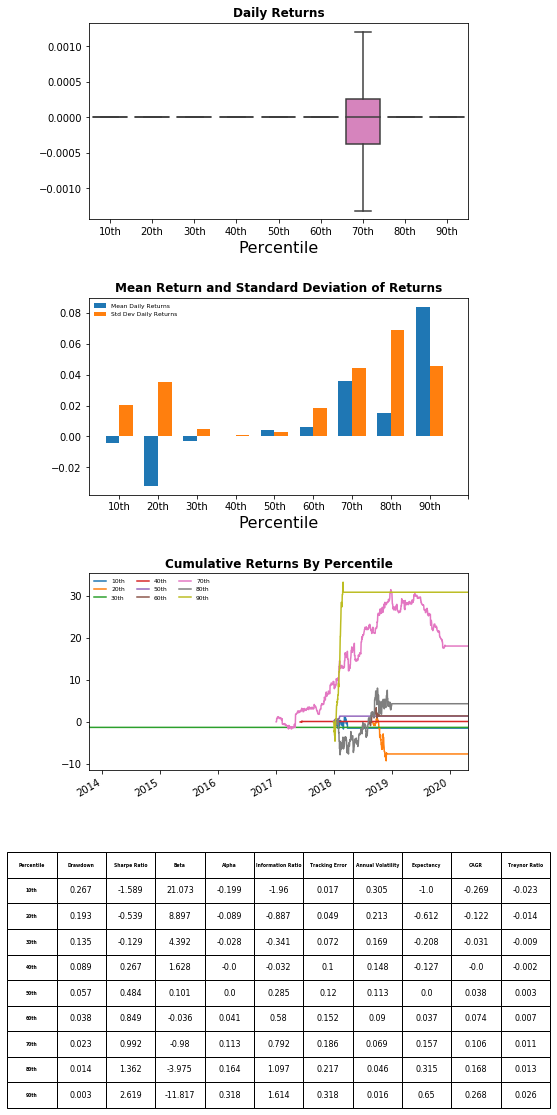

In [11]:
x = PlotPercentiles(cleaned_drawdown, cleaned_drawdown_duration, cleaned_profit_factor, cleaned_sharpe, cleaned_beta, cleaned_alpha,
                cleaned_info_ratio, cleaned_tracking_error, cleaned_std_dev,
                cleaned_expectancy, cleaned_cagr, cleaned_treynor, cleaned_mean_ret,
                cleaned_curves)

In [50]:
# Get data for distribution plots
data = [[cleaned_drawdown, cleaned_drawdown_duration],
        [cleaned_profit_factor, cleaned_sharpe],
        [cleaned_beta, cleaned_alpha],
        [cleaned_info_ratio, cleaned_tracking_error],
        [cleaned_std_dev, cleaned_expectancy],
        [cleaned_cagr, cleaned_treynor]]

In [55]:
def PlotDistributions(data = [], save = False):

    fig, axs = plt.subplots(len(data), 2, constrained_layout=True, figsize = (10,24))

    fig.tight_layout()

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

    labels = [["Drawdown", "Drawdown Duration (Hours)"], ["Profit Factor", "Sharpe Ratio"], ["Beta", "Alpha"], ["Information Ratio", "Tracking Error"],
              ['Annual Volatility', 'Expectancy'],['Compounding Annual Gross Return', 'Treynor Ratio']]

    for i, ax in enumerate(axs):
        ax[0].set_title(f"{labels[i][0]} Distribution")
        ax[0].text(0.8, 0.8, f'Mean {round(np.mean(data[i][0]),2)}\nStd {round(np.std(data[i][0]),2)}', horizontalalignment='center',
                   verticalalignment='center', transform=ax[0].transAxes, bbox={'facecolor':'white', 'edgecolor':'none', 'pad':10})
        x = sns.distplot(data[i][0], hist=True, kde=True, bins = 50, color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4}, ax = ax[0])
        if all([j >= 0 for j in data[i][0]]):
            x.set(xlim = (0))

        ax[1].set_title(f"{labels[i][1]} Distribution")
        ax[1].text(0.8, 0.8, f'Mean {round(np.mean(data[i][1]),2)}\nStd {round(np.std(data[i][1]),2)}', horizontalalignment='center',
                   verticalalignment='center', transform=ax[1].transAxes, bbox={'facecolor':'white', 'edgecolor':'none', 'pad':10})
        x = sns.distplot(data[i][1], hist=True, kde=True, bins = 50, color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4}, ax = ax[1])
        if all([j >= 0 for j in data[i][1]]):
            x.set(xlim = (0))


    if save:
        plt.savefig('C:/Users/Jack Simonson/QuantConnect/AlphaModuleEvaluationFiles/AggregateBacktestStatistics.png', dpi = 90, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

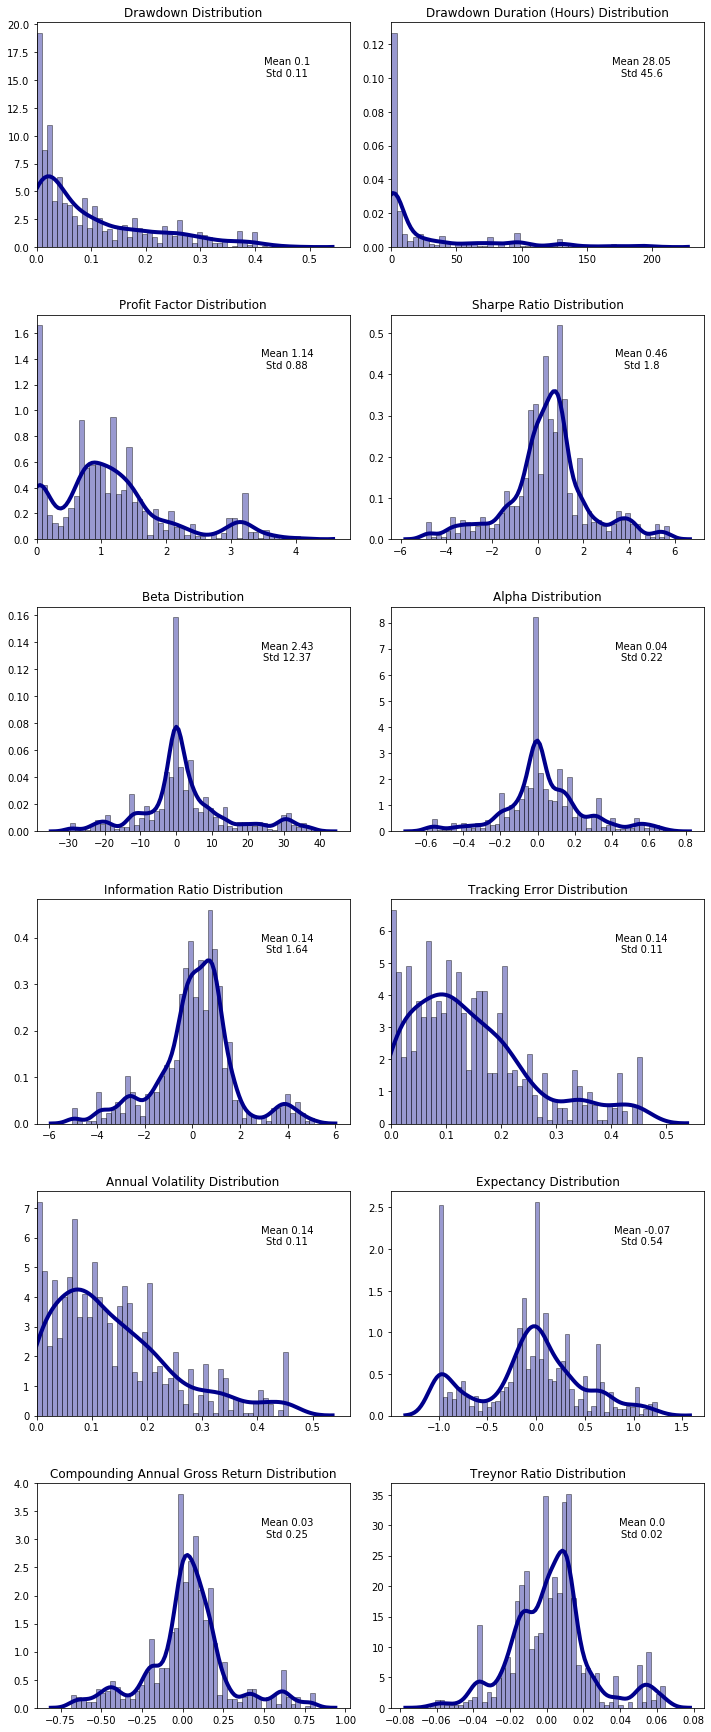

In [56]:
PlotDistributions(data)